In [1]:
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
  %pip install git+https://github.com/neelnanda-io/Easy-Transformer.git@clean-transformer-demo
  # Install another version of node that makes PySvelte work way faster
  !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
  %pip install git+https://github.com/neelnanda-io/PySvelte.git
  %pip install fancy_einsum
  %pip install einops
  %pip install ekphrasis
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for develop6ment only!")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/Easy-Transformer.git (to revision clean-transformer-demo) to /tmp/pip-req-build-wnczdjn1
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/Easy-Transformer.git /tmp/pip-req-build-wnczdjn1
  Running command git checkout -b clean-transformer-demo --track origin/clean-transformer-demo
  Switched to a new branch 'clean-transformer-demo'
  Branch 'clean-transformer-demo' set up to track remote branch 'clean-transformer-demo' from 'origin'.
  Resolved https://github.com/neelnanda-io/Easy-Transformer.git to commit 1f25219e631aeb478d17075d47274db32c874e88
  Preparing metadata (setup.py) ... done
  Created wheel for easy_transformer: filename=easy_transformer-0.1.0-py3-none-any.whl size=55600 sha256=400f8d2108584e1be793088a2d246373a60c8120c512d883c9b282e9915b5413
  Stored in directory: /tmp/pip-ephem-wheel-cache-4n_18o0t/wheels/f0/30/0b/04795723afaae8d7fff47047023153b3e8c47bab26f768cd33
Su

In [2]:
import einops
from fancy_einsum import einsum
from dataclasses import dataclass
from easy_transformer import EasyTransformer
import torch
import torch.nn as nn
import numpy as np
import math
from easy_transformer.utils import get_corner, gelu_new, tokenize_and_concatenate
import tqdm.auto as tqdm


import datasets
import transformers
import plotly.express as px
import pysvelte

from datasets import load_dataset

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
#from transformers import BertTokenizer
import string 
import re
import spacy
nlp2 = spacy.load('en_core_web_sm')
from spacy.symbols import ORTH,NORM,LEMMA
import string 
from spacy.lang.char_classes import LIST_PUNCT, LIST_ELLIPSES, LIST_QUOTES, LIST_CURRENCY
from spacy.lang.char_classes import LIST_ICONS, HYPHENS, CURRENCY, UNITS
from spacy.lang.char_classes import CONCAT_QUOTES, ALPHA_LOWER, ALPHA_UPPER, ALPHA, PUNCT
from spacy.util import compile_infix_regex, compile_prefix_regex, compile_suffix_regex

In [5]:
reference_gpt2 = EasyTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Moving model to device:  cuda
Finished loading pretrained model gpt2-small into EasyTransformer!


In [6]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12
    n_classes: int = 3

cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12, n_classes=3)


In [7]:
class LayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.d_model))
        self.b = nn.Parameter(torch.zeros(cfg.d_model))

    def forward(self, residual):
        # residual: [batch, position, d_model]
        "YOUR CODE HERE"

        residual = residual - einops.reduce(residual, "batch position d_model -> batch position 1",reduction="mean")
        scale = (einops.reduce(residual.pow(2),"batch position d_model -> batch position 1",reduction="mean" ) + + cfg.layer_norm_eps).sqrt()

        outputs = residual/scale

        outputs = outputs*self.w + self.b

        return outputs

# Embedding

In [8]:
class Embed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(torch.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, tokens):
        # tokens: [batch, position]
        "YOUR CODE HERE"
        if self.cfg.debug: print("Tokens:", tokens.shape)
        embeddings = self.W_E[tokens,:]
        if self.cfg.debug: print("Embeddings:", embeddings.shape)

        return embeddings

# Positional Embedding

In [9]:
class PosEmbed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(torch.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, tokens):
        "YOUR CODE HERE"
        if self.cfg.debug: print("Tokens:", tokens.shape)
        pos_embed = self.W_pos[:tokens.size(1), :] # [position, d_model]
        pos_embed = einops.repeat(pos_embed, "position d_model -> batch position d_model", batch=tokens.size(0))
        if self.cfg.debug: print("POS Embeddings:", pos_embeddings.shape)
        return pos_embed

# Attention

In [10]:
reference_text = "I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!"
tokens = reference_gpt2.to_tokens(reference_text)
tokens = tokens.cuda()
logits, cache = reference_gpt2.run_with_cache(tokens)
print(logits.shape)
pysvelte.AttentionMulti(tokens=reference_gpt2.to_str_tokens(reference_text), attention=cache['blocks.0.attn.hook_attn'][0].permute(1, 2, 0)).show()

torch.Size([1, 35, 50257])
pysvelte components appear to be unbuilt or stale
Running npm install...
Building pysvelte components with webpack...


In [11]:
class Attention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_O = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))

        self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32, device="cuda"))

    def forward(self, normalized_resid_pre,attention_mask=None):
        # normalized_resid_pre: [batch, position, d_model]
        "YOUR CODE HERE"

        q = einsum("batch position d_model, n_heads d_model d_head -> batch position n_heads d_head",normalized_resid_pre,self.W_Q) + self.b_Q

        k = einsum("batch position d_model, n_heads d_model d_head -> batch position n_heads d_head",normalized_resid_pre,self.W_K) + self.b_K
        v = einsum("batch position d_model, n_heads d_model d_head -> batch position n_heads d_head",normalized_resid_pre,self.W_V) + self.b_V

        score = einsum("batch qposition n_heads d_head, batch kposition n_heads d_head -> batch n_heads qposition kposition",q,k)
        score = score / math.sqrt(self.cfg.d_head)
        causal_score = self.apply_causal_mask(score)

        # Apply padding mask if provided
        if attention_mask is not None:
            score = self.apply_padding_mask(score, attention_mask)

        attn = torch.nn.Softmax(dim=-1)(causal_score)

        context = einsum("batch n_heads qposition kposition, batch kposition n_heads d_head -> batch qposition n_heads d_head",attn,v)

        context = einsum("batch position n_heads d_head, n_heads d_head d_model -> batch position d_model",context,self.W_O) + self.b_O

        return context,attn
    def apply_causal_mask(self, attn_scores):
        # attn_scores: [batch, n_heads, query_pos, key_pos]
        "YOUR CODE HERE"
        mask = torch.triu(torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device), diagonal=1).bool()

        #print(mask,self.IGNORE)
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores
    def apply_padding_mask(self, attn_score,attn_mask):
        # attn_scores: [batch, n_heads, query_pos, key_pos]
        "YOUR CODE HERE"
        expanded_mask = attn_mask.unsqueeze(1).unsqueeze(2)  # Shape: [batch, 1, 1, position]
        expanded_mask = expanded_mask.expand_as(attn_score)  # Broadcast to [batch, n_heads, query_pos, key_pos]

        attn_score.masked_fill_(expanded_mask == 0, self.IGNORE)
        return attn_score
        

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(torch.empty((cfg.d_model, cfg.d_mlp)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        self.b_in = nn.Parameter(torch.zeros((cfg.d_mlp)))
        self.W_out = nn.Parameter(torch.empty((cfg.d_mlp, cfg.d_model)))
        nn.init.normal_(self.W_out, std=self.cfg.init_range)
        self.b_out = nn.Parameter(torch.zeros((cfg.d_model)))

    def forward(self, normalized_resid_mid):
        # normalized_resid_mid: [batch, position, d_model]
        "YOUR CODE HERE"
        outputs = gelu_new(einsum("batch position d_model, d_model d_mlp -> batch position d_mlp",normalized_resid_mid,self.W_in) + self.b_in)
        outputs = einsum("batch position d_mlp, d_mlp d_model -> batch position d_model",outputs,self.W_out) + self.b_out
        return outputs

# rand_float_test(MLP, [2, 4, 768])
# load_gpt2_test(MLP, reference_gpt2.blocks[0].mlp, cache["blocks.0.ln2.hook_normalized"])

# Transformer Block

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(self, resid_pre,pad_mask):
        # resid_pre [batch, position, d_model]
        "YOUR CODE HERE"
        outputs,attn = self.attn(resid_pre,pad_mask) 
        outputs = outputs  #+ resid_pre  #self.attn(self.ln1(resid_pre)) + resid_pre
        #outputs = self.mlp(outputs)+outputs #self.mlp(self.ln2(outputs))+outputs
        return outputs,attn

# Unembedding

In [14]:
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(torch.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(torch.zeros((cfg.d_vocab), requires_grad=True))

    def forward(self, normalized_resid_final):
        # normalized_resid_final [batch, position, d_model]
        "YOUR CODE HERE"
        outputs = einsum("batch position d_model, d_model d_vocab -> batch position d_vocab", normalized_resid_final,self.W_U) + self.b_U
        return outputs

In [15]:
class Classification_Head(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(torch.empty((cfg.d_model,cfg.n_classes)))
        nn.init.normal_(self.W_U,std = self.cfg.init_range)
        self.b_U = nn.Parameter(torch.zeros((cfg.n_classes),requires_grad=True))
    def forward(self, normalized_resid_final):
        # normalized_resid_final [batch, position, d_model]
        "YOUR CODE HERE"
        outputs = einsum("batch d_model, d_model n_classes -> batch n_classes", normalized_resid_final,self.W_U) + self.b_U
        return outputs

# Decoder based Transformer

In [16]:
class DemoTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        #self.unembed = Unembed(cfg)
        self.cls_head = Classification_Head(cfg)

    def forward(self, tokens,pad_mask):
        # tokens [batch, position]
        "YOUR CODE HERE"
        embed = self.embed(tokens)
        pos_embed = self.pos_embed(tokens)
        residual = embed + pos_embed
        attention_per_block = []
        for block in self.blocks:
            residual,attn = block(residual,pad_mask)
            attention_per_block.append(attn)
        #print(residual.shape)
        normalized_resid_final = residual #self.ln_final(residual)
        pad_indices = (tokens==0 ).int().argmax(dim=1)

        #pad_mask = (torch.arange(tokens.size(1), device=device).unsqueeze(0) <= pad_indices.unsqueeze(1)).float()
        
        #print("Flag 00", tokens,pad_indices,tokens[np.arange(tokens.size(0)),pad_indices-1])
        outputs = normalized_resid_final[np.arange(normalized_resid_final.size(0)),pad_indices-1,:]
        #print(outputs.shape)
        #normalized_resid_final = einsum("batch position dmodel, batch position -> batch position dmodel", normalized_resid_final, pad_mask)
        #outputs = einops.reduce(normalized_resid_final,"batch position dmodel -> batch dmodel",reduction="sum"  ) /einops.reduce(pad_mask,"batch position -> batch 1",reduction="sum")
        
        
        
        outputs = self.cls_head(outputs)
        
        return outputs,attention_per_block

In [17]:
def lm_cross_entropy_loss(logits, tokens):
    # Measure next token loss
    # Logits have shape [batch, position, d_vocab]
    # Tokens have shape [batch, position]
    log_probs = logits.log_softmax(dim=-1)
    pred_log_probs = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    return -pred_log_probs.mean()

# Dataset

In [18]:
##### text preprocessor for ekphrasis
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    fix_html=True,  # fix HTML tokens
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    #corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)
#### Bert tokenizer
def custom_tokenize(sent,tokenizer,max_length=512):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    try:

        encoded_sent = tokenizer.encode(
                            sent,                      # Sentence to encode.
                            add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                            #max_length = max_length,
                            # This function also supports truncation and conversion
                            # to pytorch tensors, but we need to do padding, so we
                            # can't use these features :( .
                            #max_length = 128,          # Truncate all sentences.
                            #return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.

    except ValueError:
        encoded_sent = tokenizer.encode(
                            ' ',                      # Sentence to encode.
                            add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,
                    
                       )
          ### decide what to later

    return encoded_sent


#input: text
#process: ekphrasis preprocesser + some extra processing  
#output: list of tokens      
def ek_extra_preprocess(text,tokenizer):
    remove_words=['<allcaps>','</allcaps>','<hashtag>','</hashtag>','<elongated>','<emphasis>','<repeated>','\'','s']
    word_list=text_processor.pre_process_doc(text)

    word_list=list(filter(lambda a: a not in remove_words, word_list)) 
    sent=" ".join(word_list)
    sent = re.sub(r"[<\*>]", " ",sent)
    sub_word_list = custom_tokenize(sent,tokenizer)
    return sub_word_list


#input: text
#process: remove html tags  
#output: text with no html tags
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext





##### Preprocessing queries for raw text not needed for implementation
special_cases = {}
# Times
for h in range(1, 12 + 1):
    for period in ["a.m.", "am"]:
        special_cases["%d%s" % (h, period)] = [
            {ORTH: "%d" % h},
            {ORTH: period, LEMMA: "a.m.", NORM: "a.m."},
        ]
    for period in ["p.m.", "pm"]:
        special_cases["%d%s" % (h, period)] = [
            {ORTH: "%d" % h},
            {ORTH: period, LEMMA: "p.m.", NORM: "p.m."},
        ]
        
for orth in [
        "a.m.",
        "Adm.",
        "Bros.",
        "co.",
        "Co.",
        "Corp.",
        "D.C.",
        "Dr.",
        "e.g.",
        "E.g.",
        "E.G.",
        "Gen.",
        "Gov.",
        "i.e.",
        "I.e.",
        "I.E.",
        "Inc.",
        "Jr.",
        "Ltd.",
        "Md.",
        "Messrs.",
        "Mo.",
        "Mont.",
        "Mr.",
        "Mrs.",
        "Ms.",
        "p.m.",
        "Ph.D.",
        "Prof.",
        "Rep.",
        "Rev.",
        "Sen.",
        "St.",
        "vs.",
        "v.s.",
        ]:
    special_cases[orth] = [{ORTH: orth}]
    
#print (special_cases)



def preProcessing(query):
    queryLower = query.lower()
    if queryLower.startswith('eli5'):
        cutMarker = queryLower.find(' ') + 1
        query = query[cutMarker:]
    
    
    nlp2.tokenizer.rules = special_cases 
    
    #simple_url_re = re.compile(r'''^https?://''')
    #nlp2.tokenizer.token_match = {}
    
    #print(nlp.tokenizer.rules)
    prefixes = (
        ["§", "%", "=", "—", "–", r"\+(?![0-9])"]
        + LIST_PUNCT
        + LIST_ELLIPSES
        + LIST_QUOTES
        + LIST_CURRENCY
        + LIST_ICONS
    )


    suffixes = (
        LIST_PUNCT
        + LIST_ELLIPSES
        + LIST_QUOTES
        + LIST_ICONS
        + ["'s", "'S", "’s", "’S", "—", "–"]
        + [
            r"(?<=[0-9])\+",
            r"(?<=°[FfCcKk])\.",
            r"(?<=[0-9])(?:{c})".format(c=CURRENCY),
            r"(?<=[0-9])(?:{u})".format(u=UNITS),
            r"(?<=[0-9{al}{e}{p}(?:{q})])\.".format(
                al=ALPHA_LOWER, e=r"%²\-\+", q=CONCAT_QUOTES, p=PUNCT
            ),
            r"(?<=[{au}][{au}])\.".format(au=ALPHA_UPPER),
        ]
    )

    infixes = (
        LIST_ELLIPSES
        + LIST_ICONS
        + [
            r"(?<=[0-9])[+\-\*^](?=[0-9-])",
            r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
                al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
            ),
            r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
            #r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
            r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
        ]
    )

    prefixes_re = compile_prefix_regex(prefixes)
    nlp2.tokenizer.prefix_search=prefixes_re.search
    
    suffixes_re = compile_suffix_regex(suffixes)
    nlp2.tokenizer.suffix_search=suffixes_re.search
    
    infix_re = compile_infix_regex(infixes)
    nlp2.tokenizer.infix_finditer = infix_re.finditer
    
    query = query.replace('\n', ' ')
    query = query.replace('\t', ' ')
    query = re.sub(r'(\w\w)\?(\w\w)', r'\1 ? \2', query)
    query = query.replace('(', ' ( ')
    query = query.replace(')', ' ) ')
    query = query.replace('   ', ' ')
    query = query.replace('  ', ' ')
   
    doc = nlp2(query)#, disable=['parser', 'ner'])
    tokens = []
    for token in doc:
        if token.text != ' ':
            tokens.append(token.text) 
        
    if len(tokens) == 0:
        print("Zero token sentence detected!")
    return tokens

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


In [19]:
def returnMask(row,tokenizer):
    max_length = 128
    text_tokens=row['orig_sentence'].split(" ")
    #print(text_tokens)
    #print(len(text_tokens))
    #print(row[""])
    
    ##### a very rare corner case
    if(len(text_tokens)==0):
        text_tokens=['dummy']
        print("length of text ==0")
    temp_rationale = [0]*len(text_tokens)
    verb_index = row['verb_index'] - 1
    #subj_index = row['subj_index'] - 1
    temp_rationale[verb_index] = 1
    #print(temp_rationale)
    


    mask_all_temp = [temp_rationale]
    count_temp=0
    word_mask_all=[]
    word_tokens_all=[]
    
    
    for mask in mask_all_temp:
        if(mask[0]==-1):
            mask=[0]*len(mask)
        list_pos=[]
        mask_pos=[]
        flag=0
        for i in range(0,len(mask)):
            if(i==0 and mask[i]==0):
                list_pos.append(0)
                mask_pos.append(0)
            if(flag==0 and mask[i]==1):
                mask_pos.append(1)
                list_pos.append(i)
                flag=1
            elif(flag==1 and mask[i]==0):
                flag=0
                mask_pos.append(0)
                list_pos.append(i)
        if(list_pos[-1]!=len(mask)):
            list_pos.append(len(mask))
            mask_pos.append(0)

        #print(list_pos,mask_pos)    
        string_parts=[]
        for i in range(len(list_pos)-1):
            string_parts.append(text_tokens[list_pos[i]:list_pos[i+1]])
        #print("Flag 6",string_parts,len(string_parts))
 
        word_tokens=[]
        word_mask=[]

        #print(len(string_parts))
        for i in range(0,len(string_parts)):
            
            tokens=ek_extra_preprocess(" ".join(string_parts[i]),tokenizer)
            #print("Flag 5",tokens)
            #print(len(tokens))
            masks=[mask_pos[i]]*len(tokens)
            word_tokens+=tokens
            word_mask+=masks
        #print(len(word_tokens),len(word_mask))

        word_tokens=word_tokens[0:(max_length)]
        word_mask=word_mask[0:(max_length)]
        # word_tokens.append(102)
        # word_mask.append(0)

        word_mask_all.append(word_mask)
        word_tokens_all.append(word_tokens)

    
    #word_mask_all=word_mask_all[0:len(mask_all)] 

    #print(word_tokens_all,"flag11",word_mask_all)
    return word_tokens_all[0],word_mask_all    

In [20]:
import json
import pandas as pd
from transformers import BertTokenizer

In [21]:
temp_read = pd.read_table("/kaggle/input/subject-verb-agreement/agr_50_mostcommon_10K.tsv")
temp_read.head(5)

,sentence,orig_sentence,pos_sentence,subj,verb,subj_pos,has_rel,has_nsubj,verb_pos,subj_index,verb_index,n_intervening,last_intervening,n_diff_intervening,distance,max_depth,all_nouns,nouns_up_to_verb
0,NNP and NNP VBD prints are not the issue .,a0 and a1 sized prints are not the issue .,NNP CC NNP VBD NNS VBP RB DT NN .,prints,are,NNS,False,False,VBP,5,6,0,na,0,1,0,prints issue,prints
1,a JJ NN ( or JJ or JJ NN ) is nothing but a JJ...,a 0-dimensional manifold ( or differentiable o...,DT JJ NN ( CC JJ CC JJ NN ) VBZ NN CC DT JJ JJ...,manifold,is,NN,False,False,VBZ,9,11,0,na,0,2,0,NN NN nothing space,NN NN
2,NNP NNP space ( NNP ) has some precedent in wo...,a0 non-breaking space ( nbsp ) has some preced...,NNP NNP NN ( NNP ) VBZ DT NN IN NN NNS VBN IN ...,space,has,NN,False,False,VBZ,3,7,0,na,0,4,0,space precedent word NNS,space
3,"NNP , while the companion is magnitude 5 .","a0p , while the companion is magnitude 5 .","NNP , IN DT NN VBZ JJ CD .",companion,is,NN,False,False,VBZ,5,6,0,na,0,1,0,companion,companion
4,a JJ NN is not expected to get people VBG arou...,a 1000-items bibliography is not expected to g...,DT JJ NN VBZ RB VBN TO VB NNS VBG IN WP DT NN ...,author,does,NN,False,False,VBZ,14,16,0,na,0,2,0,NN people author,NN people author


In [22]:
np.unique(temp_read["verb"],return_counts=True)

(array(['ARE', 'Are', 'Do', ..., 'writes', 'yield', 'yields'], dtype=object),
 array([ 29, 426,  57, ..., 342, 108, 220]))

In [23]:
np.unique(temp_read["verb_pos"],return_counts=True)

(array(['VBP', 'VBZ'], dtype=object), array([ 502800, 1074411]))

In [24]:
data = temp_read
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)
print('total_data',len(data))
#post_ids_list=[]
text_list=[]
rationales_list=[]
label_list=[]
for index,row in tqdm.tqdm(data.iterrows(),total=len(data)):
    annotation=row['verb_pos']
    tokens,rationales = returnMask(row,tokenizer)
    rationales_list.append(rationales)
    text_list.append(tokens)
    label_list.append(annotation)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

total_data 1577211


  0%|          | 0/1577211 [00:00<?, ?it/s]

In [25]:
tokenizer.decode(torch.tensor([ 2024,1012 ]))

'are.'

In [26]:
# with open('/kaggle/input/hatexplain-dataset/post_id_divisions.json', 'r') as fp:
#     post_id_dict=json.load(fp)

In [27]:
tdata = pd.DataFrame(list(zip(text_list,rationales_list,label_list)), 
                             columns =['Text', 'Attention' , 'Label']) 

# print(len(tdata.iloc[0]["Attention"][0]))
# X_train=tdata[tdata['Post_id'].isin(post_id_dict['train'])]
# X_val=tdata[tdata['Post_id'].isin(post_id_dict['val'])]
# X_test=tdata[tdata['Post_id'].isin(post_id_dict['test'])]

In [28]:
X_train = tdata.sample(frac=0.1)
X_test = tdata.loc[~tdata.index.isin(X_train.index)]

In [29]:
X_train

,Text,Attention,Label
1407142,"[2023, 1037, 9922, 1011, 2006, 1011, 5157, 100...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",VBZ
80973,"[1998, 4283, 2005, 4851, 1010, 2023, 3160, 203...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]",VBZ
233479,"[2522, 4095, 2056, 1036, 1036, 2008, 2339, 221...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]",VBP
1533336,"[2054, 2017, 2031, 2000, 3342, 2003, 2008, 199...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",VBZ
42107,"[13392, 3006, 2003, 1037, 2460, 1011, 2973, 23...","[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",VBZ
...,...,...,...
1415628,"[2023, 3796, 3849, 2000, 2031, 2004, 2172, 200...","[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",VBZ
1303133,"[1996, 3722, 2431, 4400, 28667, 3775, 8873, 21...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",VBZ
1055265,"[1996, 16721, 2951, 3252, 2038, 2116, 5097, 1012]","[[0, 0, 0, 0, 1, 0, 0, 0]]",VBZ
1036156,"[1996, 5909, 2003, 1037, 6389, 17491, 2146, 1012]","[[0, 0, 1, 0, 0, 0, 0, 0]]",VBZ


In [30]:
class textDataset(Dataset):

    def __init__(self, data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.inputs = data["Text"]
        self.labels = data["Label"]
        self.rationales = data["Attention"]
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs.iloc[idx]

In [31]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler

In [32]:
def combine_features(tuple_data,is_train=False):
    max_length =128
    input_ids =  [ele[0] for ele in tuple_data]
    att_vals = [ele[1] for ele in tuple_data]
    labels = [ele [2] for ele in tuple_data]


    encoder = LabelEncoder()
    
    encoder.classes_ = np.array(["VBZ","VBP"])#np.load('/kaggle/input/hatexplain-dataset/classes.npy',allow_pickle=True)
    labels=encoder.transform(labels)
    
    input_ids = pad_sequences(input_ids,maxlen=max_length, 
                              dtype="long", value=0, truncating="post", padding="post")
    #print(len(att_vals))
    #print(att_vals,len(att_vals),"Flag12",len(att_vals[0]))

    rationales_vals = []
    for values in att_vals:
        temp_rationales = pad_sequences(values,maxlen=max_length, 
                                     dtype="long", value=0, truncating="post", padding="post")
        temp_rationales = torch.tensor(temp_rationales)
        rationales_vals.append(temp_rationales)
    rationales_vals = torch.stack(rationales_vals,dim=0)    
    #print(att_vals,len(att_vals),"Flag11",len(att_vals[0]))
    
    
    
    
    att_masks=custom_att_masks(input_ids)
    dataloader=return_dataloader(input_ids,labels,rationales_vals,att_masks,is_train)
    return dataloader

def return_dataloader(input_ids,labels,att_vals,att_masks,is_train=False):
    inputs = torch.tensor(input_ids)
    labels = torch.tensor(labels,dtype=torch.long)
    masks = torch.tensor(np.array(att_masks),dtype=torch.uint8)
    print(att_vals.shape)
    #attention = torch.tensor(np.array(att_vals),dtype=torch.float)
    attention = att_vals
    #print(inputs.shape,attention.shape,masks.shape,labels.shape)
    data = TensorDataset(inputs,attention,masks,labels)
    if(is_train==False):
        sampler = SequentialSampler(data)
    else:
        sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=32)
    return dataloader

In [33]:
def custom_att_masks(input_ids):
    attention_masks = []

    # For each sentence...
    for sent in input_ids:

        # Create the attention mask.256
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]

        # Store the attention mask for this sentence.
        attention_masks.append(att_mask)
    return attention_masks

In [34]:
def encodeData(dataframe):
    tuple_new_data=[]
    for index,row in tqdm.tqdm(dataframe.iterrows(),total=len(dataframe)):
        tuple_new_data.append((row['Text'],row['Attention'],row['Label']))
    return tuple_new_data

In [35]:
X_train = encodeData(X_train)
#X_val = encodeData(X_val)
X_test = encodeData(X_test)

  0%|          | 0/157721 [00:00<?, ?it/s]

  0%|          | 0/1419490 [00:00<?, ?it/s]

In [36]:
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset

In [37]:
# convert X_train to list of lists to be passed to combine features
train_dataloader = combine_features(X_train,is_train=True)
#validation_dataloader = combine_features(X_val,is_train=False)
test_dataloader=combine_features(X_test,is_train=False)

torch.Size([157721, 1, 128])
torch.Size([1419490, 1, 128])


In [38]:
# trainset = textDataset(X_train)
# valset = textDataset(X_val)
# testset = textDataset(X_test)



In [39]:
# trainloader = DataLoader(trainset, batch_size=16000, shuffle=False)
# valloader = DataLoader(valset,batch_size=3000,shuffle=False)
# testloader = DataLoader(testset,batch_size=3000,shuffle=False)

In [40]:
for c,batch in enumerate(train_dataloader):
    tokens, rationales, mask, labels = batch
    print(tokens, rationales, mask, labels)
    break

tensor([[ 2023,  2878,  6594,  ...,     0,     0,     0],
        [ 2296, 17159,  3931,  ...,     0,     0,     0],
        [ 1996,  6831,  2430,  ...,     0,     0,     0],
        ...,
        [ 1996,  2352,  2038,  ...,     0,     0,     0],
        [15966, 22942,  6685,  ...,     0,     0,     0],
        [ 2059,  2008, 10764,  ...,     0,     0,     0]]) tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 1,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.uint8) tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])


# Training Loop

In [41]:
batch_size = 32
num_epochs = 50
max_steps = 500
log_every = 480
lr = 5e-4  #2e-5 works well
weight_decay = 1e-5
model_cfg = Config(debug=False, d_model=768, n_heads=1, d_head=768, d_mlp=512, n_layers=1, n_ctx=256, d_vocab=tokenizer.vocab_size)
model = DemoTransformer(model_cfg)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay,momentum=0.99)



# optimizer = torch.optim.SGD([{'params':model.embed.parameters(),"lr":100*lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {"params":model.pos_embed.parameters(),"lr":100*lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.W_Q,'lr':100*lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.b_Q,'lr':100*lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.W_K,'lr':100*lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.b_K,'lr':100*lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.W_V,'lr':lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.b_V,'lr':lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.W_O,'lr':lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.blocks[0].attn.b_O,'lr':lr,"momentum":0.99,"weight_decay":weight_decay},
#                        {'params':model.cls_head.parameters(),'lr':lr,"momentum":0.99,"weight_decay":weight_decay},
#                            ],lr=lr)


In [42]:
for params in model.named_parameters():
    print(params[0])

embed.W_E
pos_embed.W_pos
blocks.0.ln1.w
blocks.0.ln1.b
blocks.0.attn.W_Q
blocks.0.attn.b_Q
blocks.0.attn.W_K
blocks.0.attn.b_K
blocks.0.attn.W_V
blocks.0.attn.b_V
blocks.0.attn.W_O
blocks.0.attn.b_O
blocks.0.ln2.w
blocks.0.ln2.b
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
ln_final.w
ln_final.b
cls_head.W_U
cls_head.b_U


In [43]:
from transformers import *

GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [44]:
total_steps = len(train_dataloader) * num_epochs
print(total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = int(total_steps/10),num_training_steps = total_steps)
#get_linear_schedule_with_warmup(optimizer, num_warmup_steps = int(total_steps/10), num_training_steps = total_steps)

246450


In [45]:
def calculate_performance(model,dataloader,dataset="train"):
    model.eval()
    pred = []
    gt = []
    for c, batch in tqdm.tqdm(enumerate(dataloader)):
        inputs,rationales,mask,tlabels = batch
        inputs,tlabels,mask = inputs.to(device),tlabels.to(device),mask.to(device)
        outputs,_= model(inputs,mask)
        #print(outputs.shape)
        pred.append(torch.argmax(outputs,dim=1).cpu())
        gt.append(tlabels.cpu())
        #print(len(pred))
    pred = torch.hstack(pred)
    #print(pred.size())
    gt = torch.hstack(gt)
    print("Acccuracy on "+ dataset + ":", sum(pred == gt)/len(pred))
    model.train()

In [46]:

Criterion = nn.CrossEntropyLoss()
device = "cuda"

print("Number of batches:", len(train_dataloader))
ep_loss = []
for epoch in range(num_epochs):
    losses = []
    for c, batch in tqdm.tqdm(enumerate(train_dataloader)):
        inputs,rationales,mask,tlabels = batch
        #tokens, rationales, mask, labels
        inputs,tlabels,mask = inputs.to(device),tlabels.to(device),mask.to(device)
        outputs,_ = model(inputs,mask)
        
        #print(outputs.shape,tlabels.squeeze(1).shape)
        loss_cls = Criterion(outputs,tlabels)
        #print(loss_cls)
        #loss_ntp = lm_cross_entropy_loss(logits,inputs)
        loss =  loss_cls
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if c % log_every == 0:
            print(f"Step: {c}, Loss: {loss.item():.4f}, Loss Cls: {loss_cls.item():.4f}")
    ep_loss.append(np.mean(losses))
    calculate_performance(model,train_dataloader,dataset="train_set")
    #calculate_performance(model,validation_dataloader,dataset="validation_set")
    #calculate_performance(model,test_dataloader,dataset="test_set")
        # if c > max_steps:
        #     break

Number of batches: 4929


0it [00:00, ?it/s]

Step: 0, Loss: 1.0982, Loss Cls: 1.0982
Step: 480, Loss: 1.0368, Loss Cls: 1.0368
Step: 960, Loss: 0.8611, Loss Cls: 0.8611
Step: 1440, Loss: 0.8291, Loss Cls: 0.8291
Step: 1920, Loss: 0.6448, Loss Cls: 0.6448
Step: 2400, Loss: 0.5583, Loss Cls: 0.5583
Step: 2880, Loss: 0.6956, Loss Cls: 0.6956
Step: 3360, Loss: 0.6849, Loss Cls: 0.6849
Step: 3840, Loss: 0.7066, Loss Cls: 0.7066
Step: 4320, Loss: 0.6540, Loss Cls: 0.6540
Step: 4800, Loss: 0.5523, Loss Cls: 0.5523


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.6812)


0it [00:00, ?it/s]

Step: 0, Loss: 0.6705, Loss Cls: 0.6705
Step: 480, Loss: 0.6740, Loss Cls: 0.6740
Step: 960, Loss: 0.5240, Loss Cls: 0.5240
Step: 1440, Loss: 0.5965, Loss Cls: 0.5965
Step: 1920, Loss: 0.5800, Loss Cls: 0.5800
Step: 2400, Loss: 0.6466, Loss Cls: 0.6466
Step: 2880, Loss: 0.5271, Loss Cls: 0.5271
Step: 3360, Loss: 0.5816, Loss Cls: 0.5816
Step: 3840, Loss: 0.4863, Loss Cls: 0.4863
Step: 4320, Loss: 0.6590, Loss Cls: 0.6590
Step: 4800, Loss: 0.4817, Loss Cls: 0.4817


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.6812)


0it [00:00, ?it/s]

Step: 0, Loss: 0.6876, Loss Cls: 0.6876
Step: 480, Loss: 0.5959, Loss Cls: 0.5959
Step: 960, Loss: 0.5077, Loss Cls: 0.5077
Step: 1440, Loss: 0.4433, Loss Cls: 0.4433
Step: 1920, Loss: 0.3770, Loss Cls: 0.3770
Step: 2400, Loss: 0.3874, Loss Cls: 0.3874
Step: 2880, Loss: 0.3198, Loss Cls: 0.3198
Step: 3360, Loss: 0.3353, Loss Cls: 0.3353
Step: 3840, Loss: 0.3495, Loss Cls: 0.3495
Step: 4320, Loss: 0.3131, Loss Cls: 0.3131
Step: 4800, Loss: 0.2847, Loss Cls: 0.2847


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.8665)


0it [00:00, ?it/s]

Step: 0, Loss: 0.3691, Loss Cls: 0.3691
Step: 480, Loss: 0.2832, Loss Cls: 0.2832
Step: 960, Loss: 0.3441, Loss Cls: 0.3441
Step: 1440, Loss: 0.3166, Loss Cls: 0.3166
Step: 1920, Loss: 0.2785, Loss Cls: 0.2785
Step: 2400, Loss: 0.1901, Loss Cls: 0.1901
Step: 2880, Loss: 0.2460, Loss Cls: 0.2460
Step: 3360, Loss: 0.2861, Loss Cls: 0.2861
Step: 3840, Loss: 0.1815, Loss Cls: 0.1815
Step: 4320, Loss: 0.1656, Loss Cls: 0.1656
Step: 4800, Loss: 0.2242, Loss Cls: 0.2242


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.8717)


0it [00:00, ?it/s]

Step: 0, Loss: 0.3356, Loss Cls: 0.3356
Step: 480, Loss: 0.3405, Loss Cls: 0.3405
Step: 960, Loss: 0.3221, Loss Cls: 0.3221
Step: 1440, Loss: 0.1571, Loss Cls: 0.1571
Step: 1920, Loss: 0.3737, Loss Cls: 0.3737
Step: 2400, Loss: 0.0351, Loss Cls: 0.0351
Step: 2880, Loss: 0.3349, Loss Cls: 0.3349
Step: 3360, Loss: 0.1786, Loss Cls: 0.1786
Step: 3840, Loss: 0.1605, Loss Cls: 0.1605
Step: 4320, Loss: 0.2466, Loss Cls: 0.2466
Step: 4800, Loss: 0.1995, Loss Cls: 0.1995


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9216)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1817, Loss Cls: 0.1817
Step: 480, Loss: 0.0441, Loss Cls: 0.0441
Step: 960, Loss: 0.2103, Loss Cls: 0.2103
Step: 1440, Loss: 0.1117, Loss Cls: 0.1117
Step: 1920, Loss: 0.1509, Loss Cls: 0.1509
Step: 2400, Loss: 0.1824, Loss Cls: 0.1824
Step: 2880, Loss: 0.1774, Loss Cls: 0.1774
Step: 3360, Loss: 0.1935, Loss Cls: 0.1935
Step: 3840, Loss: 0.3372, Loss Cls: 0.3372
Step: 4320, Loss: 0.0994, Loss Cls: 0.0994
Step: 4800, Loss: 0.0940, Loss Cls: 0.0940


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9272)


0it [00:00, ?it/s]

Step: 0, Loss: 0.2138, Loss Cls: 0.2138
Step: 480, Loss: 0.2521, Loss Cls: 0.2521
Step: 960, Loss: 0.2377, Loss Cls: 0.2377
Step: 1440, Loss: 0.2562, Loss Cls: 0.2562
Step: 1920, Loss: 0.2641, Loss Cls: 0.2641
Step: 2400, Loss: 0.2183, Loss Cls: 0.2183
Step: 2880, Loss: 0.1513, Loss Cls: 0.1513
Step: 3360, Loss: 0.1580, Loss Cls: 0.1580
Step: 3840, Loss: 0.0736, Loss Cls: 0.0736
Step: 4320, Loss: 0.1252, Loss Cls: 0.1252
Step: 4800, Loss: 0.2172, Loss Cls: 0.2172


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9316)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1743, Loss Cls: 0.1743
Step: 480, Loss: 0.1010, Loss Cls: 0.1010
Step: 960, Loss: 0.2987, Loss Cls: 0.2987
Step: 1440, Loss: 0.2241, Loss Cls: 0.2241
Step: 1920, Loss: 0.0775, Loss Cls: 0.0775
Step: 2400, Loss: 0.1113, Loss Cls: 0.1113
Step: 2880, Loss: 0.0642, Loss Cls: 0.0642
Step: 3360, Loss: 0.3736, Loss Cls: 0.3736
Step: 3840, Loss: 0.1445, Loss Cls: 0.1445
Step: 4320, Loss: 0.2607, Loss Cls: 0.2607
Step: 4800, Loss: 0.2111, Loss Cls: 0.2111


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9409)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1075, Loss Cls: 0.1075
Step: 480, Loss: 0.1319, Loss Cls: 0.1319
Step: 960, Loss: 0.2087, Loss Cls: 0.2087
Step: 1440, Loss: 0.1122, Loss Cls: 0.1122
Step: 1920, Loss: 0.1481, Loss Cls: 0.1481
Step: 2400, Loss: 0.2242, Loss Cls: 0.2242
Step: 2880, Loss: 0.1323, Loss Cls: 0.1323
Step: 3360, Loss: 0.0767, Loss Cls: 0.0767
Step: 3840, Loss: 0.1021, Loss Cls: 0.1021
Step: 4320, Loss: 0.2350, Loss Cls: 0.2350
Step: 4800, Loss: 0.2062, Loss Cls: 0.2062


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9434)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1499, Loss Cls: 0.1499
Step: 480, Loss: 0.1115, Loss Cls: 0.1115
Step: 960, Loss: 0.2129, Loss Cls: 0.2129
Step: 1440, Loss: 0.2177, Loss Cls: 0.2177
Step: 1920, Loss: 0.2925, Loss Cls: 0.2925
Step: 2400, Loss: 0.0542, Loss Cls: 0.0542
Step: 2880, Loss: 0.2255, Loss Cls: 0.2255
Step: 3360, Loss: 0.2184, Loss Cls: 0.2184
Step: 3840, Loss: 0.2417, Loss Cls: 0.2417
Step: 4320, Loss: 0.1963, Loss Cls: 0.1963
Step: 4800, Loss: 0.1543, Loss Cls: 0.1543


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9264)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0882, Loss Cls: 0.0882
Step: 480, Loss: 0.2607, Loss Cls: 0.2607
Step: 960, Loss: 0.2169, Loss Cls: 0.2169
Step: 1440, Loss: 0.0487, Loss Cls: 0.0487
Step: 1920, Loss: 0.0883, Loss Cls: 0.0883
Step: 2400, Loss: 0.3893, Loss Cls: 0.3893
Step: 2880, Loss: 0.0880, Loss Cls: 0.0880
Step: 3360, Loss: 0.2023, Loss Cls: 0.2023
Step: 3840, Loss: 0.0576, Loss Cls: 0.0576
Step: 4320, Loss: 0.0702, Loss Cls: 0.0702
Step: 4800, Loss: 0.1753, Loss Cls: 0.1753


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9496)


0it [00:00, ?it/s]

Step: 0, Loss: 0.2235, Loss Cls: 0.2235
Step: 480, Loss: 0.5240, Loss Cls: 0.5240
Step: 960, Loss: 0.1645, Loss Cls: 0.1645
Step: 1440, Loss: 0.3082, Loss Cls: 0.3082
Step: 1920, Loss: 0.0932, Loss Cls: 0.0932
Step: 2400, Loss: 0.2316, Loss Cls: 0.2316
Step: 2880, Loss: 0.3257, Loss Cls: 0.3257
Step: 3360, Loss: 0.0344, Loss Cls: 0.0344
Step: 3840, Loss: 0.0996, Loss Cls: 0.0996
Step: 4320, Loss: 0.0825, Loss Cls: 0.0825
Step: 4800, Loss: 0.0824, Loss Cls: 0.0824


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9506)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1299, Loss Cls: 0.1299
Step: 480, Loss: 0.2229, Loss Cls: 0.2229
Step: 960, Loss: 0.0462, Loss Cls: 0.0462
Step: 1440, Loss: 0.0993, Loss Cls: 0.0993
Step: 1920, Loss: 0.1947, Loss Cls: 0.1947
Step: 2400, Loss: 0.1653, Loss Cls: 0.1653
Step: 2880, Loss: 0.3019, Loss Cls: 0.3019
Step: 3360, Loss: 0.1111, Loss Cls: 0.1111
Step: 3840, Loss: 0.0279, Loss Cls: 0.0279
Step: 4320, Loss: 0.1437, Loss Cls: 0.1437
Step: 4800, Loss: 0.1191, Loss Cls: 0.1191


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9506)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0644, Loss Cls: 0.0644
Step: 480, Loss: 0.1643, Loss Cls: 0.1643
Step: 960, Loss: 0.0568, Loss Cls: 0.0568
Step: 1440, Loss: 0.2424, Loss Cls: 0.2424
Step: 1920, Loss: 0.1222, Loss Cls: 0.1222
Step: 2400, Loss: 0.0697, Loss Cls: 0.0697
Step: 2880, Loss: 0.1843, Loss Cls: 0.1843
Step: 3360, Loss: 0.1930, Loss Cls: 0.1930
Step: 3840, Loss: 0.1231, Loss Cls: 0.1231
Step: 4320, Loss: 0.0548, Loss Cls: 0.0548
Step: 4800, Loss: 0.1043, Loss Cls: 0.1043


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9529)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0384, Loss Cls: 0.0384
Step: 480, Loss: 0.1325, Loss Cls: 0.1325
Step: 960, Loss: 0.0517, Loss Cls: 0.0517
Step: 1440, Loss: 0.0930, Loss Cls: 0.0930
Step: 1920, Loss: 0.2218, Loss Cls: 0.2218
Step: 2400, Loss: 0.0608, Loss Cls: 0.0608
Step: 2880, Loss: 0.1670, Loss Cls: 0.1670
Step: 3360, Loss: 0.2026, Loss Cls: 0.2026
Step: 3840, Loss: 0.2692, Loss Cls: 0.2692
Step: 4320, Loss: 0.1614, Loss Cls: 0.1614
Step: 4800, Loss: 0.0548, Loss Cls: 0.0548


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9544)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1581, Loss Cls: 0.1581
Step: 480, Loss: 0.0832, Loss Cls: 0.0832
Step: 960, Loss: 0.1581, Loss Cls: 0.1581
Step: 1440, Loss: 0.0110, Loss Cls: 0.0110
Step: 1920, Loss: 0.0942, Loss Cls: 0.0942
Step: 2400, Loss: 0.1195, Loss Cls: 0.1195
Step: 2880, Loss: 0.0721, Loss Cls: 0.0721
Step: 3360, Loss: 0.0824, Loss Cls: 0.0824
Step: 3840, Loss: 0.0980, Loss Cls: 0.0980
Step: 4320, Loss: 0.2260, Loss Cls: 0.2260
Step: 4800, Loss: 0.0721, Loss Cls: 0.0721


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9432)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1056, Loss Cls: 0.1056
Step: 480, Loss: 0.0652, Loss Cls: 0.0652
Step: 960, Loss: 0.0946, Loss Cls: 0.0946
Step: 1440, Loss: 0.1194, Loss Cls: 0.1194
Step: 1920, Loss: 0.0752, Loss Cls: 0.0752
Step: 2400, Loss: 0.1084, Loss Cls: 0.1084
Step: 2880, Loss: 0.0630, Loss Cls: 0.0630
Step: 3360, Loss: 0.0935, Loss Cls: 0.0935
Step: 3840, Loss: 0.0826, Loss Cls: 0.0826
Step: 4320, Loss: 0.1625, Loss Cls: 0.1625
Step: 4800, Loss: 0.0669, Loss Cls: 0.0669


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9546)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0445, Loss Cls: 0.0445
Step: 480, Loss: 0.0756, Loss Cls: 0.0756
Step: 960, Loss: 0.1506, Loss Cls: 0.1506
Step: 1440, Loss: 0.0275, Loss Cls: 0.0275
Step: 1920, Loss: 0.1678, Loss Cls: 0.1678
Step: 2400, Loss: 0.0634, Loss Cls: 0.0634
Step: 2880, Loss: 0.0365, Loss Cls: 0.0365
Step: 3360, Loss: 0.2952, Loss Cls: 0.2952
Step: 3840, Loss: 0.0813, Loss Cls: 0.0813
Step: 4320, Loss: 0.0273, Loss Cls: 0.0273
Step: 4800, Loss: 0.0888, Loss Cls: 0.0888


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9501)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1069, Loss Cls: 0.1069
Step: 480, Loss: 0.0631, Loss Cls: 0.0631
Step: 960, Loss: 0.1239, Loss Cls: 0.1239
Step: 1440, Loss: 0.0363, Loss Cls: 0.0363
Step: 1920, Loss: 0.1264, Loss Cls: 0.1264
Step: 2400, Loss: 0.0891, Loss Cls: 0.0891
Step: 2880, Loss: 0.0505, Loss Cls: 0.0505
Step: 3360, Loss: 0.0195, Loss Cls: 0.0195
Step: 3840, Loss: 0.1115, Loss Cls: 0.1115
Step: 4320, Loss: 0.0483, Loss Cls: 0.0483
Step: 4800, Loss: 0.2270, Loss Cls: 0.2270


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9524)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1551, Loss Cls: 0.1551
Step: 480, Loss: 0.1565, Loss Cls: 0.1565
Step: 960, Loss: 0.0395, Loss Cls: 0.0395
Step: 1440, Loss: 0.2322, Loss Cls: 0.2322
Step: 1920, Loss: 0.0573, Loss Cls: 0.0573
Step: 2400, Loss: 0.0938, Loss Cls: 0.0938
Step: 2880, Loss: 0.1676, Loss Cls: 0.1676
Step: 3360, Loss: 0.0933, Loss Cls: 0.0933
Step: 3840, Loss: 0.1584, Loss Cls: 0.1584
Step: 4320, Loss: 0.1223, Loss Cls: 0.1223
Step: 4800, Loss: 0.1174, Loss Cls: 0.1174


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9589)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0581, Loss Cls: 0.0581
Step: 480, Loss: 0.0306, Loss Cls: 0.0306
Step: 960, Loss: 0.0124, Loss Cls: 0.0124
Step: 1440, Loss: 0.2566, Loss Cls: 0.2566
Step: 1920, Loss: 0.1038, Loss Cls: 0.1038
Step: 2400, Loss: 0.0905, Loss Cls: 0.0905
Step: 2880, Loss: 0.1350, Loss Cls: 0.1350
Step: 3360, Loss: 0.0547, Loss Cls: 0.0547
Step: 3840, Loss: 0.1105, Loss Cls: 0.1105
Step: 4320, Loss: 0.1138, Loss Cls: 0.1138
Step: 4800, Loss: 0.1040, Loss Cls: 0.1040


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9585)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0742, Loss Cls: 0.0742
Step: 480, Loss: 0.1561, Loss Cls: 0.1561
Step: 960, Loss: 0.0265, Loss Cls: 0.0265
Step: 1440, Loss: 0.1028, Loss Cls: 0.1028
Step: 1920, Loss: 0.0692, Loss Cls: 0.0692
Step: 2400, Loss: 0.2559, Loss Cls: 0.2559
Step: 2880, Loss: 0.0495, Loss Cls: 0.0495
Step: 3360, Loss: 0.0503, Loss Cls: 0.0503
Step: 3840, Loss: 0.2466, Loss Cls: 0.2466
Step: 4320, Loss: 0.2103, Loss Cls: 0.2103
Step: 4800, Loss: 0.2090, Loss Cls: 0.2090


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9606)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0590, Loss Cls: 0.0590
Step: 480, Loss: 0.0889, Loss Cls: 0.0889
Step: 960, Loss: 0.0797, Loss Cls: 0.0797
Step: 1440, Loss: 0.0635, Loss Cls: 0.0635
Step: 1920, Loss: 0.0997, Loss Cls: 0.0997
Step: 2400, Loss: 0.1613, Loss Cls: 0.1613
Step: 2880, Loss: 0.0876, Loss Cls: 0.0876
Step: 3360, Loss: 0.0513, Loss Cls: 0.0513
Step: 3840, Loss: 0.1392, Loss Cls: 0.1392
Step: 4320, Loss: 0.1285, Loss Cls: 0.1285
Step: 4800, Loss: 0.0726, Loss Cls: 0.0726


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9609)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1608, Loss Cls: 0.1608
Step: 480, Loss: 0.0887, Loss Cls: 0.0887
Step: 960, Loss: 0.1349, Loss Cls: 0.1349
Step: 1440, Loss: 0.2754, Loss Cls: 0.2754
Step: 1920, Loss: 0.2590, Loss Cls: 0.2590
Step: 2400, Loss: 0.1229, Loss Cls: 0.1229
Step: 2880, Loss: 0.1099, Loss Cls: 0.1099
Step: 3360, Loss: 0.0269, Loss Cls: 0.0269
Step: 3840, Loss: 0.0980, Loss Cls: 0.0980
Step: 4320, Loss: 0.1139, Loss Cls: 0.1139
Step: 4800, Loss: 0.0906, Loss Cls: 0.0906


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9547)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0597, Loss Cls: 0.0597
Step: 480, Loss: 0.1678, Loss Cls: 0.1678
Step: 960, Loss: 0.0506, Loss Cls: 0.0506
Step: 1440, Loss: 0.0255, Loss Cls: 0.0255
Step: 1920, Loss: 0.0424, Loss Cls: 0.0424
Step: 2400, Loss: 0.0516, Loss Cls: 0.0516
Step: 2880, Loss: 0.0789, Loss Cls: 0.0789
Step: 3360, Loss: 0.1295, Loss Cls: 0.1295
Step: 3840, Loss: 0.0853, Loss Cls: 0.0853
Step: 4320, Loss: 0.0787, Loss Cls: 0.0787
Step: 4800, Loss: 0.2227, Loss Cls: 0.2227


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9559)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0754, Loss Cls: 0.0754
Step: 480, Loss: 0.0821, Loss Cls: 0.0821
Step: 960, Loss: 0.1424, Loss Cls: 0.1424
Step: 1440, Loss: 0.0322, Loss Cls: 0.0322
Step: 1920, Loss: 0.0808, Loss Cls: 0.0808
Step: 2400, Loss: 0.0306, Loss Cls: 0.0306
Step: 2880, Loss: 0.0214, Loss Cls: 0.0214
Step: 3360, Loss: 0.1168, Loss Cls: 0.1168
Step: 3840, Loss: 0.0284, Loss Cls: 0.0284
Step: 4320, Loss: 0.0533, Loss Cls: 0.0533
Step: 4800, Loss: 0.0429, Loss Cls: 0.0429


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9606)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1257, Loss Cls: 0.1257
Step: 480, Loss: 0.1087, Loss Cls: 0.1087
Step: 960, Loss: 0.0818, Loss Cls: 0.0818
Step: 1440, Loss: 0.0294, Loss Cls: 0.0294
Step: 1920, Loss: 0.0581, Loss Cls: 0.0581
Step: 2400, Loss: 0.2141, Loss Cls: 0.2141
Step: 2880, Loss: 0.0492, Loss Cls: 0.0492
Step: 3360, Loss: 0.1719, Loss Cls: 0.1719
Step: 3840, Loss: 0.1528, Loss Cls: 0.1528
Step: 4320, Loss: 0.1590, Loss Cls: 0.1590
Step: 4800, Loss: 0.0607, Loss Cls: 0.0607


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9613)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0996, Loss Cls: 0.0996
Step: 480, Loss: 0.0773, Loss Cls: 0.0773
Step: 960, Loss: 0.1091, Loss Cls: 0.1091
Step: 1440, Loss: 0.0801, Loss Cls: 0.0801
Step: 1920, Loss: 0.0527, Loss Cls: 0.0527
Step: 2400, Loss: 0.0311, Loss Cls: 0.0311
Step: 2880, Loss: 0.0840, Loss Cls: 0.0840
Step: 3360, Loss: 0.0448, Loss Cls: 0.0448
Step: 3840, Loss: 0.0835, Loss Cls: 0.0835
Step: 4320, Loss: 0.0633, Loss Cls: 0.0633
Step: 4800, Loss: 0.1622, Loss Cls: 0.1622


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9624)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0682, Loss Cls: 0.0682
Step: 480, Loss: 0.0921, Loss Cls: 0.0921
Step: 960, Loss: 0.1771, Loss Cls: 0.1771
Step: 1440, Loss: 0.0696, Loss Cls: 0.0696
Step: 1920, Loss: 0.1306, Loss Cls: 0.1306
Step: 2400, Loss: 0.0104, Loss Cls: 0.0104
Step: 2880, Loss: 0.4982, Loss Cls: 0.4982
Step: 3360, Loss: 0.0198, Loss Cls: 0.0198
Step: 3840, Loss: 0.1338, Loss Cls: 0.1338
Step: 4320, Loss: 0.2642, Loss Cls: 0.2642
Step: 4800, Loss: 0.0448, Loss Cls: 0.0448


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9594)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0847, Loss Cls: 0.0847
Step: 480, Loss: 0.3769, Loss Cls: 0.3769
Step: 960, Loss: 0.0349, Loss Cls: 0.0349
Step: 1440, Loss: 0.1998, Loss Cls: 0.1998
Step: 1920, Loss: 0.1202, Loss Cls: 0.1202
Step: 2400, Loss: 0.0757, Loss Cls: 0.0757
Step: 2880, Loss: 0.1782, Loss Cls: 0.1782
Step: 3360, Loss: 0.1392, Loss Cls: 0.1392
Step: 3840, Loss: 0.2057, Loss Cls: 0.2057
Step: 4320, Loss: 0.0566, Loss Cls: 0.0566
Step: 4800, Loss: 0.0992, Loss Cls: 0.0992


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9656)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0518, Loss Cls: 0.0518
Step: 480, Loss: 0.0645, Loss Cls: 0.0645
Step: 960, Loss: 0.0323, Loss Cls: 0.0323
Step: 1440, Loss: 0.2671, Loss Cls: 0.2671
Step: 1920, Loss: 0.0448, Loss Cls: 0.0448
Step: 2400, Loss: 0.0948, Loss Cls: 0.0948
Step: 2880, Loss: 0.0708, Loss Cls: 0.0708
Step: 3360, Loss: 0.0116, Loss Cls: 0.0116
Step: 3840, Loss: 0.1840, Loss Cls: 0.1840
Step: 4320, Loss: 0.0447, Loss Cls: 0.0447
Step: 4800, Loss: 0.1156, Loss Cls: 0.1156


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9668)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0679, Loss Cls: 0.0679
Step: 480, Loss: 0.2084, Loss Cls: 0.2084
Step: 960, Loss: 0.0502, Loss Cls: 0.0502
Step: 1440, Loss: 0.0536, Loss Cls: 0.0536
Step: 1920, Loss: 0.0869, Loss Cls: 0.0869
Step: 2400, Loss: 0.1078, Loss Cls: 0.1078
Step: 2880, Loss: 0.0259, Loss Cls: 0.0259
Step: 3360, Loss: 0.1625, Loss Cls: 0.1625
Step: 3840, Loss: 0.1410, Loss Cls: 0.1410
Step: 4320, Loss: 0.1339, Loss Cls: 0.1339
Step: 4800, Loss: 0.0436, Loss Cls: 0.0436


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9663)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0603, Loss Cls: 0.0603
Step: 480, Loss: 0.0500, Loss Cls: 0.0500
Step: 960, Loss: 0.0715, Loss Cls: 0.0715
Step: 1440, Loss: 0.0420, Loss Cls: 0.0420
Step: 1920, Loss: 0.0533, Loss Cls: 0.0533
Step: 2400, Loss: 0.1184, Loss Cls: 0.1184
Step: 2880, Loss: 0.0665, Loss Cls: 0.0665
Step: 3360, Loss: 0.0227, Loss Cls: 0.0227
Step: 3840, Loss: 0.1168, Loss Cls: 0.1168
Step: 4320, Loss: 0.0242, Loss Cls: 0.0242
Step: 4800, Loss: 0.1197, Loss Cls: 0.1197


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9682)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0792, Loss Cls: 0.0792
Step: 480, Loss: 0.0524, Loss Cls: 0.0524
Step: 960, Loss: 0.0507, Loss Cls: 0.0507
Step: 1440, Loss: 0.0819, Loss Cls: 0.0819
Step: 1920, Loss: 0.3369, Loss Cls: 0.3369
Step: 2400, Loss: 0.0790, Loss Cls: 0.0790
Step: 2880, Loss: 0.0425, Loss Cls: 0.0425
Step: 3360, Loss: 0.1849, Loss Cls: 0.1849
Step: 3840, Loss: 0.2002, Loss Cls: 0.2002
Step: 4320, Loss: 0.1304, Loss Cls: 0.1304
Step: 4800, Loss: 0.0777, Loss Cls: 0.0777


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9658)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0684, Loss Cls: 0.0684
Step: 480, Loss: 0.0410, Loss Cls: 0.0410
Step: 960, Loss: 0.0574, Loss Cls: 0.0574
Step: 1440, Loss: 0.0144, Loss Cls: 0.0144
Step: 1920, Loss: 0.0262, Loss Cls: 0.0262
Step: 2400, Loss: 0.1036, Loss Cls: 0.1036
Step: 2880, Loss: 0.0069, Loss Cls: 0.0069
Step: 3360, Loss: 0.0578, Loss Cls: 0.0578
Step: 3840, Loss: 0.2047, Loss Cls: 0.2047
Step: 4320, Loss: 0.0302, Loss Cls: 0.0302
Step: 4800, Loss: 0.2414, Loss Cls: 0.2414


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9677)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1304, Loss Cls: 0.1304
Step: 480, Loss: 0.0971, Loss Cls: 0.0971
Step: 960, Loss: 0.2248, Loss Cls: 0.2248
Step: 1440, Loss: 0.0855, Loss Cls: 0.0855
Step: 1920, Loss: 0.0564, Loss Cls: 0.0564
Step: 2400, Loss: 0.1073, Loss Cls: 0.1073
Step: 2880, Loss: 0.0306, Loss Cls: 0.0306
Step: 3360, Loss: 0.0450, Loss Cls: 0.0450
Step: 3840, Loss: 0.0486, Loss Cls: 0.0486
Step: 4320, Loss: 0.0781, Loss Cls: 0.0781
Step: 4800, Loss: 0.0996, Loss Cls: 0.0996


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9703)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0972, Loss Cls: 0.0972
Step: 480, Loss: 0.0999, Loss Cls: 0.0999
Step: 960, Loss: 0.0726, Loss Cls: 0.0726
Step: 1440, Loss: 0.0282, Loss Cls: 0.0282
Step: 1920, Loss: 0.0457, Loss Cls: 0.0457
Step: 2400, Loss: 0.0199, Loss Cls: 0.0199
Step: 2880, Loss: 0.2611, Loss Cls: 0.2611
Step: 3360, Loss: 0.0593, Loss Cls: 0.0593
Step: 3840, Loss: 0.0434, Loss Cls: 0.0434
Step: 4320, Loss: 0.1600, Loss Cls: 0.1600
Step: 4800, Loss: 0.0167, Loss Cls: 0.0167


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9696)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1207, Loss Cls: 0.1207
Step: 480, Loss: 0.0741, Loss Cls: 0.0741
Step: 960, Loss: 0.0946, Loss Cls: 0.0946
Step: 1440, Loss: 0.2561, Loss Cls: 0.2561
Step: 1920, Loss: 0.1286, Loss Cls: 0.1286
Step: 2400, Loss: 0.0331, Loss Cls: 0.0331
Step: 2880, Loss: 0.1589, Loss Cls: 0.1589
Step: 3360, Loss: 0.1963, Loss Cls: 0.1963
Step: 3840, Loss: 0.0143, Loss Cls: 0.0143
Step: 4320, Loss: 0.0957, Loss Cls: 0.0957
Step: 4800, Loss: 0.0254, Loss Cls: 0.0254


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9660)


0it [00:00, ?it/s]

Step: 0, Loss: 0.2227, Loss Cls: 0.2227
Step: 480, Loss: 0.1223, Loss Cls: 0.1223
Step: 960, Loss: 0.0105, Loss Cls: 0.0105
Step: 1440, Loss: 0.1127, Loss Cls: 0.1127
Step: 1920, Loss: 0.0528, Loss Cls: 0.0528
Step: 2400, Loss: 0.0695, Loss Cls: 0.0695
Step: 2880, Loss: 0.1510, Loss Cls: 0.1510
Step: 3360, Loss: 0.1399, Loss Cls: 0.1399
Step: 3840, Loss: 0.1267, Loss Cls: 0.1267
Step: 4320, Loss: 0.0137, Loss Cls: 0.0137
Step: 4800, Loss: 0.1390, Loss Cls: 0.1390


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9708)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0874, Loss Cls: 0.0874
Step: 480, Loss: 0.0379, Loss Cls: 0.0379
Step: 960, Loss: 0.0514, Loss Cls: 0.0514
Step: 1440, Loss: 0.0586, Loss Cls: 0.0586
Step: 1920, Loss: 0.0289, Loss Cls: 0.0289
Step: 2400, Loss: 0.0272, Loss Cls: 0.0272
Step: 2880, Loss: 0.0216, Loss Cls: 0.0216
Step: 3360, Loss: 0.0420, Loss Cls: 0.0420
Step: 3840, Loss: 0.0591, Loss Cls: 0.0591
Step: 4320, Loss: 0.1561, Loss Cls: 0.1561
Step: 4800, Loss: 0.1591, Loss Cls: 0.1591


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9709)


0it [00:00, ?it/s]

Step: 0, Loss: 0.3474, Loss Cls: 0.3474
Step: 480, Loss: 0.1325, Loss Cls: 0.1325
Step: 960, Loss: 0.0911, Loss Cls: 0.0911
Step: 1440, Loss: 0.0588, Loss Cls: 0.0588
Step: 1920, Loss: 0.0589, Loss Cls: 0.0589
Step: 2400, Loss: 0.0375, Loss Cls: 0.0375
Step: 2880, Loss: 0.1946, Loss Cls: 0.1946
Step: 3360, Loss: 0.1249, Loss Cls: 0.1249
Step: 3840, Loss: 0.2219, Loss Cls: 0.2219
Step: 4320, Loss: 0.0155, Loss Cls: 0.0155
Step: 4800, Loss: 0.1165, Loss Cls: 0.1165


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9717)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0387, Loss Cls: 0.0387
Step: 480, Loss: 0.0333, Loss Cls: 0.0333
Step: 960, Loss: 0.0298, Loss Cls: 0.0298
Step: 1440, Loss: 0.0430, Loss Cls: 0.0430
Step: 1920, Loss: 0.0643, Loss Cls: 0.0643
Step: 2400, Loss: 0.0804, Loss Cls: 0.0804
Step: 2880, Loss: 0.0202, Loss Cls: 0.0202
Step: 3360, Loss: 0.1721, Loss Cls: 0.1721
Step: 3840, Loss: 0.1217, Loss Cls: 0.1217
Step: 4320, Loss: 0.0497, Loss Cls: 0.0497
Step: 4800, Loss: 0.0414, Loss Cls: 0.0414


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9720)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0709, Loss Cls: 0.0709
Step: 480, Loss: 0.0574, Loss Cls: 0.0574
Step: 960, Loss: 0.1092, Loss Cls: 0.1092
Step: 1440, Loss: 0.0997, Loss Cls: 0.0997
Step: 1920, Loss: 0.0645, Loss Cls: 0.0645
Step: 2400, Loss: 0.0912, Loss Cls: 0.0912
Step: 2880, Loss: 0.1213, Loss Cls: 0.1213
Step: 3360, Loss: 0.0547, Loss Cls: 0.0547
Step: 3840, Loss: 0.0130, Loss Cls: 0.0130
Step: 4320, Loss: 0.0370, Loss Cls: 0.0370
Step: 4800, Loss: 0.0512, Loss Cls: 0.0512


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9713)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0780, Loss Cls: 0.0780
Step: 480, Loss: 0.0493, Loss Cls: 0.0493
Step: 960, Loss: 0.0386, Loss Cls: 0.0386
Step: 1440, Loss: 0.3616, Loss Cls: 0.3616
Step: 1920, Loss: 0.0754, Loss Cls: 0.0754
Step: 2400, Loss: 0.1242, Loss Cls: 0.1242
Step: 2880, Loss: 0.1007, Loss Cls: 0.1007
Step: 3360, Loss: 0.5753, Loss Cls: 0.5753
Step: 3840, Loss: 0.0283, Loss Cls: 0.0283
Step: 4320, Loss: 0.1119, Loss Cls: 0.1119
Step: 4800, Loss: 0.0540, Loss Cls: 0.0540


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9720)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0431, Loss Cls: 0.0431
Step: 480, Loss: 0.0885, Loss Cls: 0.0885
Step: 960, Loss: 0.0539, Loss Cls: 0.0539
Step: 1440, Loss: 0.0412, Loss Cls: 0.0412
Step: 1920, Loss: 0.0921, Loss Cls: 0.0921
Step: 2400, Loss: 0.1429, Loss Cls: 0.1429
Step: 2880, Loss: 0.3575, Loss Cls: 0.3575
Step: 3360, Loss: 0.0586, Loss Cls: 0.0586
Step: 3840, Loss: 0.0638, Loss Cls: 0.0638
Step: 4320, Loss: 0.0371, Loss Cls: 0.0371
Step: 4800, Loss: 0.2034, Loss Cls: 0.2034


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9723)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0666, Loss Cls: 0.0666
Step: 480, Loss: 0.0204, Loss Cls: 0.0204
Step: 960, Loss: 0.0315, Loss Cls: 0.0315
Step: 1440, Loss: 0.3455, Loss Cls: 0.3455
Step: 1920, Loss: 0.0630, Loss Cls: 0.0630
Step: 2400, Loss: 0.1323, Loss Cls: 0.1323
Step: 2880, Loss: 0.0454, Loss Cls: 0.0454
Step: 3360, Loss: 0.1950, Loss Cls: 0.1950
Step: 3840, Loss: 0.0933, Loss Cls: 0.0933
Step: 4320, Loss: 0.0855, Loss Cls: 0.0855
Step: 4800, Loss: 0.0721, Loss Cls: 0.0721


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9724)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1615, Loss Cls: 0.1615
Step: 480, Loss: 0.0444, Loss Cls: 0.0444
Step: 960, Loss: 0.0573, Loss Cls: 0.0573
Step: 1440, Loss: 0.1316, Loss Cls: 0.1316
Step: 1920, Loss: 0.0577, Loss Cls: 0.0577
Step: 2400, Loss: 0.0834, Loss Cls: 0.0834
Step: 2880, Loss: 0.0262, Loss Cls: 0.0262
Step: 3360, Loss: 0.0503, Loss Cls: 0.0503
Step: 3840, Loss: 0.2162, Loss Cls: 0.2162
Step: 4320, Loss: 0.0858, Loss Cls: 0.0858
Step: 4800, Loss: 0.0140, Loss Cls: 0.0140


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9723)


0it [00:00, ?it/s]

Step: 0, Loss: 0.1424, Loss Cls: 0.1424
Step: 480, Loss: 0.0088, Loss Cls: 0.0088
Step: 960, Loss: 0.1518, Loss Cls: 0.1518
Step: 1440, Loss: 0.0619, Loss Cls: 0.0619
Step: 1920, Loss: 0.1444, Loss Cls: 0.1444
Step: 2400, Loss: 0.0473, Loss Cls: 0.0473
Step: 2880, Loss: 0.1208, Loss Cls: 0.1208
Step: 3360, Loss: 0.0469, Loss Cls: 0.0469
Step: 3840, Loss: 0.0883, Loss Cls: 0.0883
Step: 4320, Loss: 0.0819, Loss Cls: 0.0819
Step: 4800, Loss: 0.0453, Loss Cls: 0.0453


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9725)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0527, Loss Cls: 0.0527
Step: 480, Loss: 0.1184, Loss Cls: 0.1184
Step: 960, Loss: 0.0902, Loss Cls: 0.0902
Step: 1440, Loss: 0.0406, Loss Cls: 0.0406
Step: 1920, Loss: 0.0549, Loss Cls: 0.0549
Step: 2400, Loss: 0.0494, Loss Cls: 0.0494
Step: 2880, Loss: 0.0945, Loss Cls: 0.0945
Step: 3360, Loss: 0.1666, Loss Cls: 0.1666
Step: 3840, Loss: 0.0198, Loss Cls: 0.0198
Step: 4320, Loss: 0.2678, Loss Cls: 0.2678
Step: 4800, Loss: 0.1018, Loss Cls: 0.1018


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9725)


0it [00:00, ?it/s]

Step: 0, Loss: 0.0636, Loss Cls: 0.0636
Step: 480, Loss: 0.0131, Loss Cls: 0.0131
Step: 960, Loss: 0.0683, Loss Cls: 0.0683
Step: 1440, Loss: 0.3036, Loss Cls: 0.3036
Step: 1920, Loss: 0.2617, Loss Cls: 0.2617
Step: 2400, Loss: 0.0185, Loss Cls: 0.0185
Step: 2880, Loss: 0.0834, Loss Cls: 0.0834
Step: 3360, Loss: 0.0447, Loss Cls: 0.0447
Step: 3840, Loss: 0.1468, Loss Cls: 0.1468
Step: 4320, Loss: 0.0392, Loss Cls: 0.0392
Step: 4800, Loss: 0.0569, Loss Cls: 0.0569


0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9725)


In [47]:
#px.line(y=losses, x=np.arange(len(losses))*(model_cfg.n_ctx * batch_size), labels={"y":"Loss", "x":"Tokens"}, title="Training curve for my tiny demo model!")
px.line(y=ep_loss,x=np.arange(len(ep_loss)))

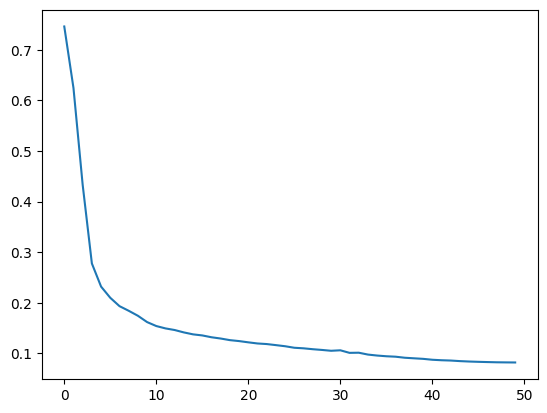

In [48]:
plt.plot(np.arange(len(ep_loss)),ep_loss)

In [49]:
calculate_performance(model,train_dataloader,dataset="train_set")
#calculate_performance(model,validation_dataloader,dataset="validation_set")
calculate_performance(model,test_dataloader,dataset="test_set")



0it [00:00, ?it/s]

Acccuracy on train_set: tensor(0.9725)


0it [00:00, ?it/s]

Acccuracy on test_set: tensor(0.9234)


In [50]:
def plot_heatmaps(model,dataloader,name):
    attn_values = []
    prediction_values = []
    for c, batch in tqdm.tqdm(enumerate(dataloader)):
        inputs,rationales,mask,tlabels = batch
        inputs,tlabels,mask = inputs.to(device),tlabels.to(device),mask.to(device)
        outputs,attn= model(inputs,mask)
        outputs = nn.Softmax(dim=1)(outputs)
        for i in range(len(attn[0])):
            temp_attn = attn[0][i,0,-1].cpu().detach().numpy()
            temp_1 = 0 
            for rationale in rationales[i]:
                temp_rationale = rationale
                indices = temp_rationale.long().cpu().numpy()
                temp_1 += sum(temp_attn[indices.astype(bool)])
            attn_values.append(temp_1/len(rationales[0]))
            #print(temp_1,attn_values[-1],len(rationales))
            prediction_values.append(outputs[i,tlabels[i]].item())
    print(sum( np.array(attn_values)<=0.1))
    print("attention",sum( np.array(attn_values)<=0.1)/len(attn_values),sum(np.logical_and(np.array(attn_values)>0.1, np.array(attn_values)<=0.5))/len(attn_values),sum(np.array(attn_values)>0.5)/len(attn_values))
    print("prediction",sum( np.array(prediction_values)<=0.1)/len(prediction_values),sum(np.logical_and(np.array(prediction_values)>0.1, np.array(prediction_values)<=0.5))/len(prediction_values),sum(np.array(prediction_values)>0.5)/len(prediction_values))
    fig, ax = plt.subplots()
    h, xedges, yedges, im = ax.hist2d(np.array(attn_values),np.array(prediction_values),[[0,0.1,0.5,1.1],[0,0.5,1.1]])
    plt.close(fig)
    temp = (h.T/h.sum())*100

    # Prevent automatic plotting by removing `plt.show()`
    # or manually remove the image
    im.remove()  # This prevents the heatmap from being displayed
    plt.figure(figsize=(7,7))
    ax = sns.heatmap(np.round(temp,2),vmin=5,vmax=70,annot=np.round(temp,2),fmt="g",cmap=sns.color_palette("coolwarm"),
    yticklabels=[0.5,1.],
    xticklabels=[0.1,0.5,1],annot_kws={"size":18},cbar=False)
    ax.invert_yaxis()
    plt.xlabel(r"distinct token attention",fontweight="bold",fontsize=14)
    plt.ylabel(r"true token probability",fontweight="bold",fontsize=14) # change xlabel based on algo
    plt.xticks([0,1,2,3],[0,0.1,0.5,1],weight="bold",fontsize=14)
    plt.yticks([0,1,2],[0,0.5,1],weight="bold", va="top",fontsize=14)
    plt.savefig(name+".pdf",bbox_inches='tight')

0it [00:00, ?it/s]

144761
attention 0.9178295851535306 0.08217041484646939 0.0
prediction 0.006295927619023465 0.021208336239308654 0.9724957361416678


0it [00:00, ?it/s]

1303263
attention 0.918120592607204 0.081879407392796 0.0
prediction 0.0341911531606422 0.04243143664273789 0.9233774101966199


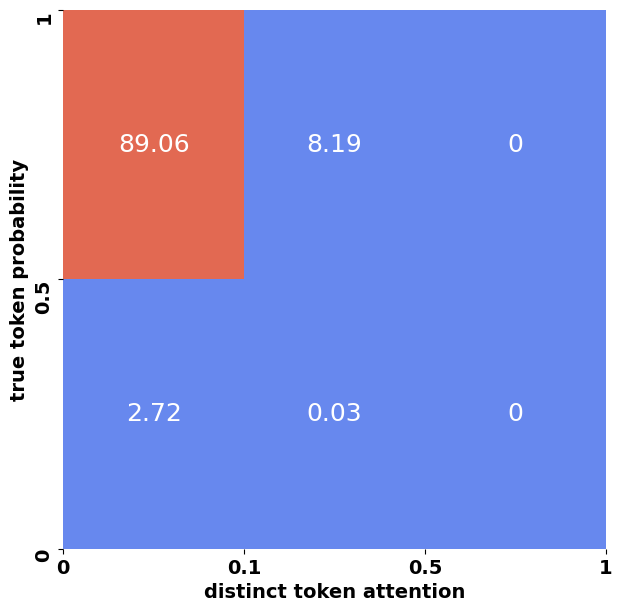

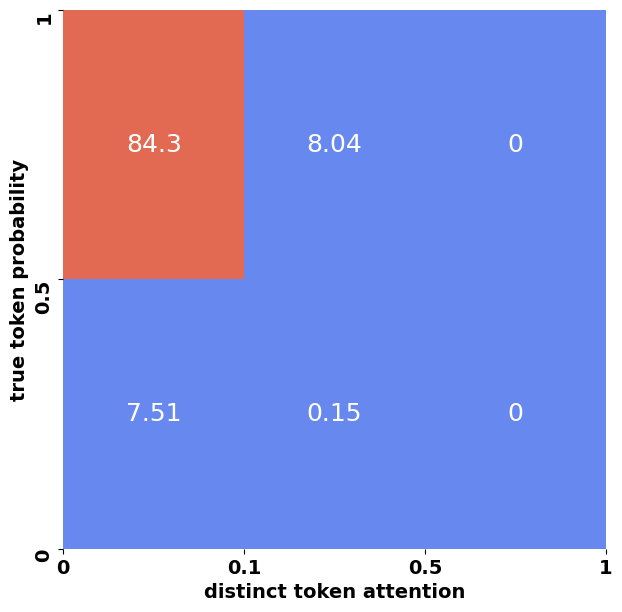

In [51]:
setting1 = "same_lr_train_no_res_connection_sva"
#setting2 = "same_lr_validation_no_res_connection"
setting3 = "same_lr_test_no_res_connection_sva"
plot_heatmaps(model,train_dataloader,name = setting1)
#plot_heatmaps(model,validation_dataloader,name = setting2)
plot_heatmaps(model,test_dataloader,name = setting3)

In [52]:
count = 0 
for c, batch in tqdm.tqdm(enumerate(train_dataloader)):
    inputs,rationales,mask,tlabels = batch
    inputs,tlabels,mask = inputs.to(device),tlabels.to(device),mask.to(device)
    outputs,attn= model(inputs,mask)
    outputs = nn.Softmax(dim=1)(outputs)
    
    for i in range(len(attn[0])):
        temp_attn = attn[0][i,0,-1].cpu().detach().numpy()
        temp = 0 
        for rationale in rationales[i]:
            temp_rationale = rationale
            indices = temp_rationale.long().cpu().numpy()
            temp += sum(temp_attn[indices.astype(bool)])
        if temp>=0.1:
            count +=1 
        #print(count)
        

0it [00:00, ?it/s]

In [53]:
count

12960

In [54]:
count = 0 
for c, batch in tqdm.tqdm(enumerate(test_dataloader)):
    inputs,rationales,mask,tlabels = batch
    inputs,tlabels,mask = inputs.to(device),tlabels.to(device),mask.to(device)
    outputs,attn= model(inputs,mask)
    outputs = nn.Softmax(dim=1)(outputs)
    
    for i in range(len(attn[0])):
        temp_attn = attn[0][i,0,-1].cpu().detach().numpy()
        temp = 0 
        for rationale in rationales[i]:
            temp_rationale = rationale
            indices = temp_rationale.long().cpu().numpy()
            temp += sum(temp_attn[indices.astype(bool)])
        if temp>=0.1:
            count +=1 
        #print(count)
        

0it [00:00, ?it/s]

In [55]:
count

116227

In [56]:
    # model.eval()
    # pred = []
    # gt = []
    # for c, batch in tqdm.tqdm(enumerate(dataloader)):
    #     inputs,rationales,mask,tlabels = batch
    #     inputs,tlabels,mask = inputs.to(device),tlabels.to(device),mask.to(device)
    #     _,outputs,_= model(inputs)
    #     #print(outputs.shape)
    #     pred.append(torch.argmax(outputs,dim=1).cpu())
    #     gt.append(tlabels.cpu())
    #     #print(len(pred))
    # pred = torch.hstack(pred)
    # #print(pred.size())
    # gt = torch.hstack(gt)
    # print("Acccuracy on "+ dataset + ":", sum(pred == gt)/len(pred))
    # model.train()